In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import requests
from dotenv import load_dotenv
import os

# Load data

In [2]:
# Read data from csv
df = pd.read_csv("data/rental_prices_singapore.csv")

In [3]:
# Show dataframe info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5360 entries, 0 to 5359
Data columns (total 9 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   name                           5360 non-null   object 
 1   address                        5011 non-null   object 
 2   price                          5360 non-null   object 
 3   size                           5360 non-null   object 
 4   bedrooms                       5360 non-null   object 
 5   bathrooms                      4941 non-null   float64
 6   property_type_furnishing_year  5360 non-null   object 
 7   mrt_distance                   4641 non-null   object 
 8   agent_description              5360 non-null   object 
dtypes: float64(1), object(8)
memory usage: 377.0+ KB


In [4]:
# Show top five rows
df.head()

,name,address,price,size,bedrooms,bathrooms,property_type_furnishing_year,mrt_distance,agent_description
0,"Brand new Attic Studio, in a Peranakan Conserv...",Lorong 34 Geylang,"3,000",400 sqft,1,1.0,\nApartment\nFully Furnished\n,NaN,One and only attic studio! Beautifully done up...
1,Astor,51C Lengkong Empat,"2,000",1130 sqft,Room,NaN,\nApartment\nFully Furnished\n,11 mins (810 m) to DT28 Kaki Bukit MRT,Comes with In House Maid
2,Springhill Terrace,Sunrise avenue,"7,400",3800 sqft,5,4.0,\nApartment\nFully Furnished\n,NaN,"Close to MRT and short drive to French, Austra..."
3,704 Yishun Avenue 5,704 Yishun Avenue 5,"1,000",120 sqft,Room,NaN,\nApartment\nFully Furnished\n,9 mins (700 m) to NS13 Yishun MRT,Room for 1 or 2 single ladies
4,Espada,48 Saint Thomas Walk,"4,300",689 sqft,1,1.0,\nApartment\nFully Furnished\n,6 mins (420 m) to NS23 Somerset MRT,All units virtual online viewing available! An...


# Remove duplicates

In [5]:
# Diagnose duplicates
df.duplicated(subset=["name", "price", "size"]).value_counts()

True     3655
False    1705
dtype: int64

In [6]:
# Remove duplicates
df = df.drop_duplicates(subset=["name", "price", "size"]).copy()

In [7]:
# Show dataframe info
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1705 entries, 0 to 5019
Data columns (total 9 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   name                           1705 non-null   object 
 1   address                        1577 non-null   object 
 2   price                          1705 non-null   object 
 3   size                           1705 non-null   object 
 4   bedrooms                       1705 non-null   object 
 5   bathrooms                      1536 non-null   float64
 6   property_type_furnishing_year  1705 non-null   object 
 7   mrt_distance                   1489 non-null   object 
 8   agent_description              1705 non-null   object 
dtypes: float64(1), object(8)
memory usage: 133.2+ KB


# Data enrichment: Fill in missing addresses

In [8]:
# Load environment variables from .env file
load_dotenv()

True

In [9]:
# Get Google Maps API key from .env 
google_maps_api_key = os.getenv("google_maps_api_key")

In [10]:
# Create function to get missing address based on the property name via Google Maps API
def get_missing_address(row):
    # Check if address is missing
    if pd.isna(row["address"]): 
        # Base URL for the Google Maps Find Place API
        base_url = "https://maps.googleapis.com/maps/api/place/findplacefromtext/json"

        # Parameters for the Find Place API request
        params = {
            "input": f"{row['name']}, Singapore",
            "inputtype": "textquery",
            "fields": "formatted_address",
            "key": google_maps_api_key
        }

        # Send Find Place API request and store the response
        response = requests.get(base_url, params=params)
        data = response.json()

        # Check if request was successful
        if data["status"] == "OK":
            # Extract address from the response
            address = data["candidates"][0]["formatted_address"]
        # If no address was found, give notification and use the original value (i.e. np.nan)
        else:
            print(f"No address found for {row['name']}")
            address = row["address"]
    # If an address is present, use that address
    else:
        address = row["address"]
    # Return address
    return address

In [11]:
# Apply function to get missing addresses and store them in "address_new" column
# Cost: 2.18$. More precisely, 0.017$ per API call for 128 missing addresses.
# df["address_new"] = df.apply(get_missing_address, axis=1)

In [12]:
# Save enriched dataframe as csv
# df.to_csv("data/preprocessing/rental_prices_singapore_preprocessing_1.csv", index=False)

In [13]:
# Load enriched data
df = pd.read_csv("data/preprocessing/rental_prices_singapore_preprocessing_1.csv")

In [14]:
# Show dataframe info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1705 entries, 0 to 1704
Data columns (total 10 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   name                           1705 non-null   object 
 1   address                        1577 non-null   object 
 2   price                          1705 non-null   object 
 3   size                           1705 non-null   object 
 4   bedrooms                       1705 non-null   object 
 5   bathrooms                      1536 non-null   float64
 6   property_type_furnishing_year  1705 non-null   object 
 7   mrt_distance                   1489 non-null   object 
 8   agent_description              1705 non-null   object 
 9   address_new                    1682 non-null   object 
dtypes: float64(1), object(9)
memory usage: 133.3+ KB


In [15]:
# Percent missing addresses before
print(f'Percent missing addresses before: {100 * pd.isna(df["address"]).sum() / pd.isna(df["address"]).count():.1f}%')

Percent missing addresses before: 7.5%


In [16]:
# Percent missing addresses after 
print(f'Percent missing addresses after: {100 * pd.isna(df["address_new"]).sum() / pd.isna(df["address_new"]).count():.1f}%')

Percent missing addresses after: 1.3%


In [17]:
# Delete the remaining 23 missing addresses
df.dropna(subset=["address_new"], inplace=True)

In [18]:
# Show dataframe info
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1682 entries, 0 to 1704
Data columns (total 10 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   name                           1682 non-null   object 
 1   address                        1577 non-null   object 
 2   price                          1682 non-null   object 
 3   size                           1682 non-null   object 
 4   bedrooms                       1682 non-null   object 
 5   bathrooms                      1514 non-null   float64
 6   property_type_furnishing_year  1682 non-null   object 
 7   mrt_distance                   1473 non-null   object 
 8   agent_description              1682 non-null   object 
 9   address_new                    1682 non-null   object 
dtypes: float64(1), object(9)
memory usage: 144.5+ KB


# Feature engineering

## Latitude and longitude

In [19]:
# Create function to get latitude and longitude from an address 
def get_latitude_longitude(address):
    # Base URL for the Google Maps Geocoding API
    base_url = "https://maps.googleapis.com/maps/api/geocode/json"
    
    # Parameters for the Geocoding API request
    params = {
        "address": f"{address}, Singapore",
        "key": google_maps_api_key
    }
    
    # Send Geocoding API request and store the response
    response = requests.get(base_url, params=params)
    data = response.json()
    
    # Check if request was successful
    if data["status"] == "OK":
        # Extract latitude and longitude from the response
        location = data["results"][0]["geometry"]["location"]
        latitude = location["lat"]
        longitude = location["lng"]
    else:
        # Assign missing values and print error message if the request failed
        latitude = np.nan
        longitude = np.nan
        print(f"Geocoding request failed for {address}")
    
    # Return latitude and longitude
    return (latitude, longitude)

In [20]:
# Apply function to create latitude and longitude column 
# Cost: 8.41$. More precisely, 0.005$ per API call for 1682 addresses.
# df[["latitude", "longitude"]] = df["address_new"].apply(get_latitude_longitude).apply(pd.Series)

In [21]:
# Save enriched dataframe as csv
# df.to_csv("data/preprocessing/rental_prices_singapore_preprocessing_2.csv", index=False)

In [22]:
# Load enriched data
df = pd.read_csv("data/preprocessing/rental_prices_singapore_preprocessing_2.csv")

In [23]:
# Show dataframe info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1682 entries, 0 to 1681
Data columns (total 12 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   name                           1682 non-null   object 
 1   address                        1577 non-null   object 
 2   price                          1682 non-null   object 
 3   size                           1682 non-null   object 
 4   bedrooms                       1682 non-null   object 
 5   bathrooms                      1514 non-null   float64
 6   property_type_furnishing_year  1682 non-null   object 
 7   mrt_distance                   1473 non-null   object 
 8   agent_description              1682 non-null   object 
 9   address_new                    1682 non-null   object 
 10  latitude                       1680 non-null   float64
 11  longitude                      1680 non-null   float64
dtypes: float64(3), object(9)
memory usage: 157.8+ KB

## Meters to central business district

In [24]:
# Create function to get meters to central business district 
def get_meters_to_cbd(row):
    # Get latitude and longitude of the property
    property_latitude = row["latitude"]
    property_longitude = row["longitude"]
    
    # Return a missing value if latitude or longitude is missing
    if np.isnan(property_latitude) or np.isnan(property_longitude):
        print(f"Property latitude or longitude missing for {row['address_new']}")
        return np.nan
    
    # Latitude and longitude of central business district (i.e. Raffles Place)
    cbd_latitude = 1.284184
    cbd_longitude = 103.85151

    # Base URL for the Google Maps Distance Matrix API
    base_url = "https://maps.googleapis.com/maps/api/distancematrix/json"
    
    # Parameters for the Distance Matrix API request
    params = {
        "origins": f"{property_latitude},{property_longitude}",
        "destinations": f"{cbd_latitude},{cbd_longitude}",
        "key": google_maps_api_key
    }

    # Send the Distance Matrix API request and store the response
    response = requests.get(base_url, params=params)
    data = response.json()

    # Process the response to get the distance
    if "rows" in data and data["rows"]:
        meters_to_cbd = data["rows"][0]["elements"][0]["distance"]["value"]
        print(f"Distance between property and CBD: {meters_to_cbd} meters")
    else:
        print("No distance information available.")
        return np.nan
    return meters_to_cbd

In [25]:
# Apply function to create the "meters_to_cbd" column 
# Cost: 8.4$. More precisely, 0.005$ per distance for 1680 distances.
# df["meters_to_cbd"] = df.apply(get_meters_to_cbd, axis=1)

In [26]:
# Save enriched dataframe as csv
# df.to_csv("data/preprocessing/rental_prices_singapore_preprocessing_3.csv", index=False)

In [27]:
# Load enriched data
df = pd.read_csv("data/preprocessing/rental_prices_singapore_preprocessing_3.csv")

In [28]:
# Show dataframe info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1682 entries, 0 to 1681
Data columns (total 13 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   name                           1682 non-null   object 
 1   address                        1577 non-null   object 
 2   price                          1682 non-null   object 
 3   size                           1682 non-null   object 
 4   bedrooms                       1682 non-null   object 
 5   bathrooms                      1514 non-null   float64
 6   property_type_furnishing_year  1682 non-null   object 
 7   mrt_distance                   1473 non-null   object 
 8   agent_description              1682 non-null   object 
 9   address_new                    1682 non-null   object 
 10  latitude                       1680 non-null   float64
 11  longitude                      1680 non-null   float64
 12  meters_to_cbd                  1680 non-null   f

## Meters to school

In [29]:
# Create function to get latitude and longitude of the closest school 
def get_school_location(row):
    # Get latitude and longitude of the property
    property_latitude = row["latitude"]
    property_longitude = row["longitude"]
    
    # Return missing value if latitude or longitude is missing
    if np.isnan(property_latitude) or np.isnan(property_longitude):
        print(f"Property latitude or longitude missing for {row['address_new']}")
        return (np.nan, np.nan)
    
    # Base URL for the Google Maps Places Nearby Search API
    base_url = "https://maps.googleapis.com/maps/api/place/nearbysearch/json"

    # Parameters for the Nearby Search API request
    params = {
        "location": f"{property_latitude},{property_longitude}",
        "radius": 1000,  # Search radius in meters
        "type": "school",
        "key": google_maps_api_key
    }

    # Send the Nearby Search API request and store the response
    response = requests.get(base_url, params=params)
    data = response.json()
    
    # Extract latitude and longitude of the closest school from the response
    if "results" in data and data["results"]:
        closest_school = data["results"][0]
        school_name = closest_school["name"]
        school_location = closest_school["geometry"]["location"]
        school_latitude = school_location["lat"]
        school_longitude = school_location["lng"]
        print(f"Closest school: {school_name}")
        print(f"Latitude: {school_latitude}, Longitude: {school_longitude}")
    else:
        school_latitude = np.nan
        school_longitude = np.nan
        print("No schools found nearby.")
    return (school_latitude, school_longitude)

In [31]:
# Apply function to create the "school_location" column 
# Cost: 53.76$. More precisely, 0.032$ per API call for 1680 properties.
# df["school_location"] = df.apply(get_school_location, axis=1)

Closest school: Kong Hwa School
Latitude: 1.311089, Longitude: 103.8881773
Closest school: Bedok North Secondary School
Latitude: 1.3347987, Longitude: 103.9102302
Closest school: Kinderland Educare Services Pte Ltd
Latitude: 1.3910834, Longitude: 103.8539132
Closest school: Averbel Child Development Centre Pte Ltd
Latitude: 1.4296647, Longitude: 103.8334817
Closest school: Ngee Ann Academy
Latitude: 1.3025578, Longitude: 103.83456
Closest school: Raffles Girls' School
Latitude: 1.311665, Longitude: 103.8287358
Closest school: AnneExeProject educational centre
Latitude: 1.3178207, Longitude: 103.9012
Closest school: Bedok North Secondary School
Latitude: 1.3347987, Longitude: 103.9102302
Closest school: Stamford American International School Singapore
Latitude: 1.3373841, Longitude: 103.8689783
Closest school: ACS (Barker Road)
Latitude: 1.3195029, Longitude: 103.8360442
Closest school: St Margaret's School (Secondary)
Latitude: 1.3199548, Longitude: 103.8100803
Closest school: Kinderl

Closest school: Uptrend College (Suntec City)
Latitude: 1.2953267, Longitude: 103.8596246
Closest school: Ngee Ann Academy
Latitude: 1.3025578, Longitude: 103.83456
Closest school: Gan Eng Seng School
Latitude: 1.2900347, Longitude: 103.8235117
Closest school: Monks Hill Secondary School
Latitude: 1.3090785, Longitude: 103.8412437
Closest school: International French School (IFS)
Latitude: 1.371349, Longitude: 103.8671195
No schools found nearby.
Closest school: Think Psychological Services
Latitude: 1.2994903, Longitude: 103.84201
Closest school: Canadian International School
Latitude: 1.3456729, Longitude: 103.727018
Closest school: FTMS Global Academy
Latitude: 1.2847149, Longitude: 103.8526892
Closest school: Highlander Coffee Espresso Bar
Latitude: 1.276779, Longitude: 103.83613
Closest school: Yuvabharathi International School
Latitude: 1.3292077, Longitude: 103.7232514
Closest school: Maris Stella High School
Latitude: 1.3411414, Longitude: 103.8776654
Closest school: Assumption

Closest school: Spring College International
Latitude: 1.333788, Longitude: 103.739684
Closest school: Bukit Panjang Government High School
Latitude: 1.3815132, Longitude: 103.7388106
Closest school: JHS Montessori
Latitude: 1.2792979, Longitude: 103.7886034
Closest school: ACTFA School of Dance & Performing Arts
Latitude: 1.3086521, Longitude: 103.8512435
Closest school: Raffles Girls' School
Latitude: 1.311665, Longitude: 103.8287358
Closest school: Raffles Girls' School
Latitude: 1.311665, Longitude: 103.8287358
Closest school: Sembawang Secondary School
Latitude: 1.4454666, Longitude: 103.8168532
Closest school: Outram Secondary School
Latitude: 1.286507, Longitude: 103.837091
Closest school: Titan Academy
Latitude: 1.352083, Longitude: 103.819836
Closest school: Federation Of Art Societies (Singapore)
Latitude: 1.3183889, Longitude: 103.9066
Closest school: SSTC Institute
Latitude: 1.2644615, Longitude: 103.8201179
Closest school: Raffles Girls' School
Latitude: 1.311665, Longitud

Closest school: Methodist Girls' School
Latitude: 1.3329949, Longitude: 103.783453
Closest school: Little Wings Kindergarten - Block 307
Latitude: 1.321439, Longitude: 103.7670964
Closest school: Bendemeer Secondary School
Latitude: 1.3245163, Longitude: 103.8605913
Closest school: National Junior College
Latitude: 1.330476, Longitude: 103.8045
Closest school: Outram Secondary School
Latitude: 1.286507, Longitude: 103.837091
Closest school: Henry Park Primary School
Latitude: 1.3167825, Longitude: 103.7841363
Closest school: Overseas Family School
Latitude: 1.3809575, Longitude: 103.9419055
Closest school: Nanyang Primary School
Latitude: 1.3205401, Longitude: 103.80852
Closest school: Queensway Secondary School
Latitude: 1.3000009, Longitude: 103.8027544
Closest school: Ngee Ann Academy
Latitude: 1.3025578, Longitude: 103.83456
Closest school: Concept Math Novena
Latitude: 1.3185189, Longitude: 103.8429045
Closest school: Titan Academy
Latitude: 1.352083, Longitude: 103.819836
Closest

Closest school: ACS (Barker Road)
Latitude: 1.3195029, Longitude: 103.8360442
Closest school: Highlander Coffee Espresso Bar
Latitude: 1.276779, Longitude: 103.83613
Closest school: JCS Japanese Language School
Latitude: 1.2989794, Longitude: 103.8536803
Closest school: Raffles Girls' School
Latitude: 1.311665, Longitude: 103.8287358
Closest school: Overseas Family School
Latitude: 1.3809575, Longitude: 103.9419055
Closest school: Gan Eng Seng School
Latitude: 1.2900347, Longitude: 103.8235117
Closest school: Bedok South Secondary School
Latitude: 1.325588, Longitude: 103.9514666
Closest school: Kong Hwa School
Latitude: 1.311089, Longitude: 103.8881773
Closest school: Friendly Waters Seasports Pte. Ltd.
Latitude: 1.2888899, Longitude: 103.8483573
Closest school: Highlander Coffee Espresso Bar
Latitude: 1.276779, Longitude: 103.83613
Closest school: KyungHee Taekwondo (Bukit Timah)
Latitude: 1.3423741, Longitude: 103.7762593
Closest school: North Vista Secondary School
Latitude: 1.3812

Closest school: Compassvale Secondary School
Latitude: 1.3960452, Longitude: 103.9002456
Closest school: Blossom Educare Centre (Hougang)
Latitude: 1.3706787, Longitude: 103.8975087
Closest school: Outram Secondary School
Latitude: 1.286507, Longitude: 103.837091
Closest school: Stamford American International School Singapore
Latitude: 1.3373841, Longitude: 103.8689783
Closest school: Raffles Girls' School
Latitude: 1.311665, Longitude: 103.8287358
Closest school: Elias Park Primary School
Latitude: 1.3749538, Longitude: 103.9452385
Closest school: International French School (IFS)
Latitude: 1.371349, Longitude: 103.8671195
Closest school: Ngee Ann Academy
Latitude: 1.3025578, Longitude: 103.83456
Closest school: Ngee Ann Secondary School
Latitude: 1.3544373, Longitude: 103.9569646
Closest school: Outram Secondary School
Latitude: 1.286507, Longitude: 103.837091
Property latitude or longitude missing for 111 Tampines Road
Closest school: CHIJ Katong (Primary)
Latitude: 1.3064102, Long

Closest school: Stamford American International School Singapore
Latitude: 1.3373841, Longitude: 103.8689783
Closest school: Gan Eng Seng School
Latitude: 1.2900347, Longitude: 103.8235117
Closest school: Outram Secondary School
Latitude: 1.286507, Longitude: 103.837091
Closest school: Ngee Ann Academy
Latitude: 1.3025578, Longitude: 103.83456
Closest school: Princess Elizabeth Primary School
Latitude: 1.3494947, Longitude: 103.7410015
Closest school: Christ Church Secondary School
Latitude: 1.4263994, Longitude: 103.7934218
Closest school: Dunman High School
Latitude: 1.2986982, Longitude: 103.882844
Closest school: Compassvale Secondary School
Latitude: 1.3960452, Longitude: 103.9002456
Closest school: Singapore SwimSG Swimming Lessons (Hougang Serangoon)
Latitude: 1.3698831, Longitude: 103.8875236
Closest school: DPS International School
Latitude: 1.3540635, Longitude: 103.8837121
Closest school: Compassvale Secondary School
Latitude: 1.3960452, Longitude: 103.9002456
Closest school

Closest school: KyungHee Taekwondo (Bukit Timah)
Latitude: 1.3423741, Longitude: 103.7762593
Closest school: CHIJ Our Lady of Good Counsel
Latitude: 1.3574239, Longitude: 103.8637879
Closest school: International French School (IFS)
Latitude: 1.371349, Longitude: 103.8671195
Closest school: Sengkang Secondary School
Latitude: 1.3865592, Longitude: 103.8985521
Closest school: Queensway Secondary School
Latitude: 1.3000009, Longitude: 103.8027544
Closest school: International French School (IFS)
Latitude: 1.371349, Longitude: 103.8671195
Closest school: Les Oliviers French/English Montessori
Latitude: 1.3239943, Longitude: 103.7967618
Closest school: Star Learners @ Telok Blangah
Latitude: 1.2736207, Longitude: 103.8081962
Closest school: Outram Secondary School
Latitude: 1.286507, Longitude: 103.837091
Closest school: Sembawang Secondary School
Latitude: 1.4454666, Longitude: 103.8168532
Closest school: Star Learners @ Telok Blangah
Latitude: 1.2736207, Longitude: 103.8081962
Closest sc

Closest school: Kong Hwa School
Latitude: 1.311089, Longitude: 103.8881773
Closest school: Tanjong Katong Secondary School
Latitude: 1.3083557, Longitude: 103.897532
Closest school: Bedok South Secondary School
Latitude: 1.325588, Longitude: 103.9514666
Closest school: Highlander Coffee Espresso Bar
Latitude: 1.276779, Longitude: 103.83613
Closest school: Nan Hua Primary School
Latitude: 1.3197989, Longitude: 103.7619428
Closest school: Raffles Institution
Latitude: 1.3466071, Longitude: 103.843095
Closest school: Nan Hua Primary School
Latitude: 1.3197989, Longitude: 103.7619428
Closest school: Ngee Ann Academy
Latitude: 1.3025578, Longitude: 103.83456
Closest school: Holland International School & Preschool
Latitude: 1.3454676, Longitude: 103.7899095
Closest school: Highlander Coffee Espresso Bar
Latitude: 1.276779, Longitude: 103.83613
Closest school: Stamford American International School Singapore
Latitude: 1.3373841, Longitude: 103.8689783
Closest school: Assumption Pathway Schoo

Closest school: Greendale Secondary School
Latitude: 1.3974271, Longitude: 103.9118624
Closest school: Gan Eng Seng School
Latitude: 1.2900347, Longitude: 103.8235117
Closest school: Monks Hill Secondary School
Latitude: 1.3090785, Longitude: 103.8412437
Closest school: Highlander Coffee Espresso Bar
Latitude: 1.276779, Longitude: 103.83613
Closest school: Titan Academy
Latitude: 1.352083, Longitude: 103.819836
Closest school: Swiss Cottage Secondary School
Latitude: 1.3646741, Longitude: 103.7506408
Closest school: FTMS Global Academy
Latitude: 1.2847149, Longitude: 103.8526892
Closest school: Nanyang Primary School
Latitude: 1.3205401, Longitude: 103.80852
Closest school: Ngee Ann Academy
Latitude: 1.3025578, Longitude: 103.83456
Closest school: JHS Montessori
Latitude: 1.2792979, Longitude: 103.7886034
Closest school: Monks Hill Secondary School
Latitude: 1.3090785, Longitude: 103.8412437
Closest school: Australian International School Singapore
Latitude: 1.348726, Longitude: 103.85

Closest school: Play By Ear Music School
Latitude: 1.300452, Longitude: 103.855312
Closest school: Federation Of Art Societies (Singapore)
Latitude: 1.3183889, Longitude: 103.9066
Closest school: Overseas Family School
Latitude: 1.3809575, Longitude: 103.9419055
Closest school: Kay Poh Road Baptist Kindergarten
Latitude: 1.2966789, Longitude: 103.8291795
Closest school: Konohana Kindergarten
Latitude: 1.2982222, Longitude: 103.889879
Closest school: Tanjong Katong Secondary School
Latitude: 1.3083557, Longitude: 103.897532
Closest school: Spring College International
Latitude: 1.333788, Longitude: 103.739684
Closest school: Ngee Ann Secondary School
Latitude: 1.3544373, Longitude: 103.9569646
Closest school: Admiralty Secondary School
Latitude: 1.4462673, Longitude: 103.8026082
Closest school: Ngee Ann Academy
Latitude: 1.3025578, Longitude: 103.83456
Closest school: Blossom Educare Centre (Hougang)
Latitude: 1.3706787, Longitude: 103.8975087
Closest school: PCF Care Services
Latitude:

Closest school: National Junior College
Latitude: 1.330476, Longitude: 103.8045
Closest school: Australian International School Singapore
Latitude: 1.348726, Longitude: 103.8592611
Closest school: Ngee Ann Academy
Latitude: 1.3025578, Longitude: 103.83456
Closest school: Outram Secondary School
Latitude: 1.286507, Longitude: 103.837091
Closest school: Ngee Ann Academy
Latitude: 1.3025578, Longitude: 103.83456
Closest school: Maris Stella Kindergarten
Latitude: 1.3087161, Longitude: 103.8086403
Closest school: Leo Magan Speech Sanctuary Pte Ltd
Latitude: 1.3010722, Longitude: 103.8424588
Closest school: Gramercy Music School
Latitude: 1.3104069, Longitude: 103.7953615
Closest school: Ngee Ann Academy
Latitude: 1.3025578, Longitude: 103.83456
Closest school: Ngee Ann Academy
Latitude: 1.3025578, Longitude: 103.83456
Closest school: Assumption Pathway School
Latitude: 1.3706115, Longitude: 103.7664257
Closest school: JCS Japanese Language School
Latitude: 1.2989794, Longitude: 103.8536803

Closest school: East Spring Primary School
Latitude: 1.3529446, Longitude: 103.9618398
Closest school: National Junior College
Latitude: 1.330476, Longitude: 103.8045
Closest school: ACS (Barker Road)
Latitude: 1.3195029, Longitude: 103.8360442
Closest school: Ang Mo Kio Secondary School
Latitude: 1.3672319, Longitude: 103.8426326
Closest school: National Junior College
Latitude: 1.330476, Longitude: 103.8045
Closest school: Tanjong Katong Secondary School
Latitude: 1.3083557, Longitude: 103.897532
Closest school: Methodist Girls' School
Latitude: 1.3329949, Longitude: 103.783453
Closest school: Overseas Family School
Latitude: 1.3809575, Longitude: 103.9419055
Closest school: Singapore Chinese Girls' School
Latitude: 1.3212977, Longitude: 103.828876
Closest school: Compassvale Secondary School
Latitude: 1.3960452, Longitude: 103.9002456
Closest school: Highlander Coffee Espresso Bar
Latitude: 1.276779, Longitude: 103.83613
Closest school: Brain Revolution Pte Ltd
Latitude: 1.3181977, 

Closest school: Ngee Ann Academy
Latitude: 1.3025578, Longitude: 103.83456
Closest school: Bukit Panjang Government High School
Latitude: 1.3815132, Longitude: 103.7388106
Closest school: Ngee Ann Academy
Latitude: 1.3025578, Longitude: 103.83456
Closest school: Ngee Ann Academy
Latitude: 1.3025578, Longitude: 103.83456
Closest school: Sembawang Secondary School
Latitude: 1.4454666, Longitude: 103.8168532
Closest school: Nanyang Primary School
Latitude: 1.3205401, Longitude: 103.80852
Closest school: Canadian International School
Latitude: 1.3456729, Longitude: 103.727018
Closest school: International French School (IFS)
Latitude: 1.371349, Longitude: 103.8671195
Closest school: Kinderland Preschool @ Ministry of National Development
Latitude: 1.279519, Longitude: 103.8465378
Closest school: Little Skool-House Ulu Pandan Community Club (Buona Vista - By The Vista)
Latitude: 1.3122873, Longitude: 103.7896595
Closest school: Tanjong Katong Secondary School
Latitude: 1.3083557, Longitude:

Closest school: Greendale Secondary School
Latitude: 1.3974271, Longitude: 103.9118624
Closest school: Boon Lay Secondary School
Latitude: 1.343319, Longitude: 103.7019012
Closest school: Riverside Secondary School
Latitude: 1.4404834, Longitude: 103.788591
Closest school: Ngee Ann Academy
Latitude: 1.3025578, Longitude: 103.83456
Closest school: Methodist Girls' School
Latitude: 1.3329949, Longitude: 103.783453
Closest school: International French School (IFS)
Latitude: 1.371349, Longitude: 103.8671195
Closest school: Singapore SwimSG Swimming Lessons (Hougang Serangoon)
Latitude: 1.3698831, Longitude: 103.8875236
Closest school: Raffles Girls' School
Latitude: 1.311665, Longitude: 103.8287358
Closest school: Methodist Girls' School
Latitude: 1.3329949, Longitude: 103.783453
Closest school: FP Vocal Training Studio
Latitude: 1.319015, Longitude: 103.923625
Closest school: Yio Chu Kang Secondary School.
Latitude: 1.3783445, Longitude: 103.8420058
Closest school: FTMS Global Academy
Lat

Closest school: Anderson Secondary School
Latitude: 1.3751207, Longitude: 103.8515701
Closest school: Crescent Girls' School
Latitude: 1.2940214, Longitude: 103.8168823
Closest school: Star Learners @ Sembawang Place
Latitude: 1.43938, Longitude: 103.824555
Closest school: Presbyterian High School
Latitude: 1.3821667, Longitude: 103.843
Closest school: Methodist Girls' School
Latitude: 1.3329949, Longitude: 103.783453
Closest school: Methodist Girls' School
Latitude: 1.3329949, Longitude: 103.783453
Closest school: Star Learners @ Telok Blangah
Latitude: 1.2736207, Longitude: 103.8081962
Closest school: Star Learners @ Telok Blangah
Latitude: 1.2736207, Longitude: 103.8081962
Closest school: Bedok Green Secondary School
Latitude: 1.3341416, Longitude: 103.935336
Closest school: Expert Tutor - Home Tutor
Latitude: 1.404923, Longitude: 103.89684
Closest school: Expert Tutor - Home Tutor
Latitude: 1.404923, Longitude: 103.89684
Closest school: Maris Stella High School
Latitude: 1.3411414,

Closest school: Sengkang Secondary School
Latitude: 1.3865592, Longitude: 103.8985521
Closest school: Raffles Institution
Latitude: 1.3466071, Longitude: 103.843095
Closest school: KyungHee Taekwondo (Bukit Timah)
Latitude: 1.3423741, Longitude: 103.7762593
Closest school: Beatty Secondary School
Latitude: 1.3416799, Longitude: 103.8518807
Closest school: Ngee Ann Academy
Latitude: 1.3025578, Longitude: 103.83456
Closest school: Yishun Town Secondary School
Latitude: 1.4326229, Longitude: 103.8379391
Closest school: Titan Academy
Latitude: 1.352083, Longitude: 103.819836
Closest school: ACS (Barker Road)
Latitude: 1.3195029, Longitude: 103.8360442
Closest school: The Montessori Playroom Kindergarten
Latitude: 1.371151, Longitude: 103.8941304
Closest school: Swiss Cottage Secondary School
Latitude: 1.3646741, Longitude: 103.7506408
Closest school: Nanyang Primary School
Latitude: 1.3205401, Longitude: 103.80852
Closest school: Raffles Institution
Latitude: 1.3466071, Longitude: 103.8430

Closest school: Spring College International
Latitude: 1.333788, Longitude: 103.739684
Closest school: Ngee Ann Academy
Latitude: 1.3025578, Longitude: 103.83456
Closest school: Anglo-Chinese Junior College
Latitude: 1.3031354, Longitude: 103.785109
Closest school: Spring College International
Latitude: 1.333788, Longitude: 103.739684
Closest school: Nan Chiau High School
Latitude: 1.3894247, Longitude: 103.8899758
Closest school: Play By Ear Music School
Latitude: 1.300452, Longitude: 103.855312
Closest school: Ngee Ann Academy
Latitude: 1.3025578, Longitude: 103.83456
Closest school: ACTFA School of Dance & Performing Arts
Latitude: 1.3086521, Longitude: 103.8512435
Closest school: Play By Ear Music School
Latitude: 1.300452, Longitude: 103.855312
Closest school: Paya Lebar Methodist Girls' School (Primary)
Latitude: 1.3504619, Longitude: 103.8852195
Closest school: St. Gabriel's Secondary School
Latitude: 1.3470106, Longitude: 103.8757857
Closest school: Kong Hwa School
Latitude: 1.

In [32]:
# Save enriched dataframe as csv
# df.to_csv("data/preprocessing/rental_prices_singapore_preprocessing_4.csv", index=False)

In [33]:
# Load enriched data
df = pd.read_csv("data/preprocessing/rental_prices_singapore_preprocessing_4.csv")

In [34]:
# Show dataframe info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1682 entries, 0 to 1681
Data columns (total 14 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   name                           1682 non-null   object 
 1   address                        1577 non-null   object 
 2   price                          1682 non-null   object 
 3   size                           1682 non-null   object 
 4   bedrooms                       1682 non-null   object 
 5   bathrooms                      1514 non-null   float64
 6   property_type_furnishing_year  1682 non-null   object 
 7   mrt_distance                   1473 non-null   object 
 8   agent_description              1682 non-null   object 
 9   address_new                    1682 non-null   object 
 10  latitude                       1680 non-null   float64
 11  longitude                      1680 non-null   float64
 12  meters_to_cbd                  1680 non-null   f

In [44]:
# Create function to get meters to the closest school 
def get_meters_to_school(row):
    # Get latitude and longitude of the property
    property_latitude = row["latitude"]
    property_longitude = row["longitude"]
    
    # Return missing value if property latitude or longitude is missing
    if np.isnan(property_latitude) or np.isnan(property_longitude):
        print(f"Property latitude or longitude missing for {row['address_new']}")
        return np.nan
    
    # Get latitude and longitude of the school
    # Return missing value if the school location is missing
    if row["school_location"]=="(nan, nan)":
        print(f"School location missing for {row['address_new']}")
        return np.nan
    # Remove parentheses and split the string by comma
    latitude_str, longitude_str = row["school_location"].strip("()").split(",")
    # Convert the strings to float values
    school_latitude = float(latitude_str)
    school_longitude = float(longitude_str)

    # Base URL for the Google Maps Distance Matrix API
    base_url = "https://maps.googleapis.com/maps/api/distancematrix/json"
    
    # Parameters for the Distance Matrix API request
    params = {
        "origins": f"{property_latitude},{property_longitude}",
        "destinations": f"{school_latitude},{school_longitude}",
        "key": google_maps_api_key
    }

    # Send the Distance Matrix API request and store the response
    response = requests.get(base_url, params=params)
    data = response.json()

    # Process the response to get the distance
    if "rows" in data and data["rows"]:
        meters_to_school = data["rows"][0]["elements"][0]["distance"]["value"]
        print(f"Distance between property and closest school: {meters_to_school} meters")
    else:
        print("No distance information available.")
        return np.nan
    return meters_to_school

In [45]:
# Apply function to create the "meters_to_school" column 
# Cost: 8.4$. More precisely, 0.005$ per distance for 1680 distances.
# df["meters_to_school"] = df.apply(get_meters_to_school, axis=1)

Distance between property and closest school: 422 meters
Distance between property and closest school: 3422 meters
Distance between property and closest school: 568 meters
Distance between property and closest school: 1090 meters
Distance between property and closest school: 1262 meters
Distance between property and closest school: 1802 meters
Distance between property and closest school: 586 meters
Distance between property and closest school: 3569 meters
Distance between property and closest school: 643 meters
Distance between property and closest school: 521 meters
Distance between property and closest school: 1732 meters
Distance between property and closest school: 576 meters
Distance between property and closest school: 894 meters
Distance between property and closest school: 805 meters
Distance between property and closest school: 1046 meters
Distance between property and closest school: 1247 meters
Distance between property and closest school: 1541 meters
Distance between prope

Distance between property and closest school: 1589 meters
Distance between property and closest school: 1934 meters
Distance between property and closest school: 2053 meters
Distance between property and closest school: 894 meters
Distance between property and closest school: 636 meters
Distance between property and closest school: 1235 meters
Distance between property and closest school: 2107 meters
Distance between property and closest school: 604 meters
Distance between property and closest school: 1376 meters
Distance between property and closest school: 1422 meters
Distance between property and closest school: 1511 meters
Distance between property and closest school: 1234 meters
Distance between property and closest school: 797 meters
Distance between property and closest school: 1230 meters
Distance between property and closest school: 1383 meters
Distance between property and closest school: 1882 meters
Distance between property and closest school: 2368 meters
Distance between p

Distance between property and closest school: 2774 meters
Distance between property and closest school: 1843 meters
Distance between property and closest school: 1487 meters
Distance between property and closest school: 1162 meters
Distance between property and closest school: 1626 meters
Distance between property and closest school: 1150 meters
Distance between property and closest school: 2688 meters
Distance between property and closest school: 2009 meters
Distance between property and closest school: 1020 meters
Distance between property and closest school: 0 meters
Distance between property and closest school: 5879 meters
Distance between property and closest school: 684 meters
Distance between property and closest school: 587 meters
Distance between property and closest school: 1018 meters
Distance between property and closest school: 1230 meters
Distance between property and closest school: 894 meters
Distance between property and closest school: 863 meters
Distance between prop

Distance between property and closest school: 3518 meters
Distance between property and closest school: 1525 meters
Distance between property and closest school: 963 meters
Distance between property and closest school: 892 meters
Distance between property and closest school: 4888 meters
Distance between property and closest school: 1132 meters
Distance between property and closest school: 3567 meters
Distance between property and closest school: 1132 meters
Distance between property and closest school: 0 meters
Distance between property and closest school: 186 meters
Distance between property and closest school: 1395 meters
Distance between property and closest school: 2166 meters
Distance between property and closest school: 1312 meters
Distance between property and closest school: 1358 meters
Distance between property and closest school: 1370 meters
Distance between property and closest school: 683 meters
Distance between property and closest school: 225 meters
Distance between prope

Distance between property and closest school: 1701 meters
Distance between property and closest school: 737 meters
Distance between property and closest school: 1654 meters
Distance between property and closest school: 1455 meters
Distance between property and closest school: 2479 meters
Distance between property and closest school: 2359 meters
Distance between property and closest school: 1343 meters
Distance between property and closest school: 2031 meters
Distance between property and closest school: 1188 meters
Distance between property and closest school: 294 meters
Distance between property and closest school: 1180 meters
Distance between property and closest school: 891 meters
Distance between property and closest school: 2537 meters
Distance between property and closest school: 797 meters
Distance between property and closest school: 1013 meters
Distance between property and closest school: 894 meters
Distance between property and closest school: 1024 meters
Distance between pr

Distance between property and closest school: 1220 meters
Distance between property and closest school: 1220 meters
Distance between property and closest school: 3124 meters
Distance between property and closest school: 3451 meters
Distance between property and closest school: 1170 meters
Distance between property and closest school: 2366 meters
Distance between property and closest school: 950 meters
Distance between property and closest school: 1424 meters
Distance between property and closest school: 0 meters
Distance between property and closest school: 1104 meters
Distance between property and closest school: 513 meters
Distance between property and closest school: 2322 meters
Distance between property and closest school: 2203 meters
Distance between property and closest school: 992 meters
Distance between property and closest school: 928 meters
Distance between property and closest school: 1498 meters
Distance between property and closest school: 3270 meters
Distance between prop

Distance between property and closest school: 1126 meters
Distance between property and closest school: 1784 meters
Distance between property and closest school: 1162 meters
Distance between property and closest school: 2143 meters
Distance between property and closest school: 3466 meters
Distance between property and closest school: 52 meters
Distance between property and closest school: 1826 meters
Distance between property and closest school: 1422 meters
Distance between property and closest school: 1501 meters
Distance between property and closest school: 2894 meters
Distance between property and closest school: 2080 meters
Distance between property and closest school: 2507 meters
Distance between property and closest school: 298 meters
Distance between property and closest school: 1148 meters
Distance between property and closest school: 1692 meters
Distance between property and closest school: 934 meters
Distance between property and closest school: 1477 meters
Distance between p

Distance between property and closest school: 2010 meters
Distance between property and closest school: 2226 meters
Distance between property and closest school: 223 meters
Distance between property and closest school: 3410 meters
Distance between property and closest school: 897 meters
Distance between property and closest school: 897 meters
Distance between property and closest school: 308 meters
Distance between property and closest school: 1603 meters
Distance between property and closest school: 1942 meters
Distance between property and closest school: 2353 meters
Distance between property and closest school: 1727 meters
Distance between property and closest school: 2392 meters
Distance between property and closest school: 1838 meters
Distance between property and closest school: 1009 meters
Distance between property and closest school: 1203 meters
Distance between property and closest school: 1862 meters
Distance between property and closest school: 865 meters
Distance between pr

Distance between property and closest school: 684 meters
Distance between property and closest school: 1444 meters
Distance between property and closest school: 1976 meters
Distance between property and closest school: 1230 meters
Distance between property and closest school: 1368 meters
Distance between property and closest school: 1116 meters
Distance between property and closest school: 227 meters
Distance between property and closest school: 838 meters
Distance between property and closest school: 2638 meters
Distance between property and closest school: 2455 meters
Distance between property and closest school: 990 meters
Distance between property and closest school: 1365 meters
Distance between property and closest school: 649 meters
Distance between property and closest school: 1230 meters
Distance between property and closest school: 1138 meters
Distance between property and closest school: 2104 meters
Distance between property and closest school: 3790 meters
Distance between pr

Distance between property and closest school: 1424 meters
Distance between property and closest school: 1239 meters
Distance between property and closest school: 1996 meters
Distance between property and closest school: 2702 meters
Distance between property and closest school: 1484 meters
Distance between property and closest school: 2237 meters
Distance between property and closest school: 1440 meters
Distance between property and closest school: 1054 meters
Distance between property and closest school: 1185 meters
Distance between property and closest school: 268 meters
Distance between property and closest school: 1276 meters
Distance between property and closest school: 1553 meters
Distance between property and closest school: 1059 meters
Distance between property and closest school: 1592 meters
Distance between property and closest school: 1149 meters
Distance between property and closest school: 1274 meters
Distance between property and closest school: 1598 meters
Distance betwee

Distance between property and closest school: 2219 meters
Distance between property and closest school: 585 meters
Distance between property and closest school: 2036 meters
Distance between property and closest school: 1023 meters
Distance between property and closest school: 517 meters
Distance between property and closest school: 736 meters
Distance between property and closest school: 1349 meters
Distance between property and closest school: 1755 meters
Distance between property and closest school: 1589 meters
Distance between property and closest school: 894 meters
Distance between property and closest school: 700 meters
Distance between property and closest school: 587 meters
Distance between property and closest school: 920 meters
Distance between property and closest school: 1710 meters
Distance between property and closest school: 1495 meters
Distance between property and closest school: 357 meters
Distance between property and closest school: 1021 meters
Distance between prope

Distance between property and closest school: 347 meters
Distance between property and closest school: 2704 meters
Distance between property and closest school: 1402 meters
Distance between property and closest school: 1231 meters
Distance between property and closest school: 2629 meters
Distance between property and closest school: 1662 meters
Distance between property and closest school: 1023 meters
Distance between property and closest school: 856 meters
Distance between property and closest school: 2010 meters
Distance between property and closest school: 1300 meters
Distance between property and closest school: 2648 meters
Distance between property and closest school: 949 meters
Distance between property and closest school: 1046 meters
Distance between property and closest school: 3669 meters
Distance between property and closest school: 3270 meters
Distance between property and closest school: 1536 meters
Distance between property and closest school: 3742 meters
Distance between 

In [46]:
# Save enriched dataframe as csv
# df.to_csv("data/preprocessing/rental_prices_singapore_preprocessing_5.csv", index=False)

In [47]:
# Load enriched data
df = pd.read_csv("data/preprocessing/rental_prices_singapore_preprocessing_5.csv")

In [48]:
# Show dataframe info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1682 entries, 0 to 1681
Data columns (total 15 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   name                           1682 non-null   object 
 1   address                        1577 non-null   object 
 2   price                          1682 non-null   object 
 3   size                           1682 non-null   object 
 4   bedrooms                       1682 non-null   object 
 5   bathrooms                      1514 non-null   float64
 6   property_type_furnishing_year  1682 non-null   object 
 7   mrt_distance                   1473 non-null   object 
 8   agent_description              1682 non-null   object 
 9   address_new                    1682 non-null   object 
 10  latitude                       1680 non-null   float64
 11  longitude                      1680 non-null   float64
 12  meters_to_cbd                  1680 non-null   f

## Good restaurants nearby

In [49]:
# Create function to get the average Google Maps rating of nearby restaurants 
def get_restaurants_rating(row):
    # Get latitude and longitude of the property
    property_latitude = row["latitude"]
    property_longitude = row["longitude"]
    
    # Return missing value if latitude or longitude is missing
    if np.isnan(property_latitude) or np.isnan(property_longitude):
        print(f"Property latitude or longitude missing for {row['address_new']}")
        return np.nan
    
    # Base URL for the Google Maps Places Nearby Search API
    base_url = "https://maps.googleapis.com/maps/api/place/nearbysearch/json"

    # Parameters for the Nearby Search API request
    params = {
        "location": f"{property_latitude},{property_longitude}",
        "radius": 1000,  # Search radius in meters
        "type": "restaurant",
        "key": google_maps_api_key
    }

    # Send the Nearby Search API request and store the response
    response = requests.get(base_url, params=params)
    data = response.json()
    
    # Process the response to get the average restaurant rating
    if "results" in data and data["results"]:
        # Extract restaurant ratings as a list, assigning np.nan for missing ratings
        rating_list = [restaurant.get("rating", np.nan) for restaurant in data.get("results")]
        # Calculate average rating, ignoring np.nan values
        average_rating = np.nanmean(rating_list)
        print(f"Number of restaurants: {len(rating_list)}")
        print(f"Number of ratings: {len([rating for rating in rating_list if not np.isnan(rating)])}")
        print(f"Average rating: {average_rating:.2f}")
    else:
        print("No restaurants found nearby.")
        return np.nan
    return average_rating

In [50]:
# Apply function to create the "restaurants_rating" column 
# Cost: 53.76$. More precisely, 0.032$ per API call for 1680 properties.
# df["restaurants_rating"] = df.apply(get_restaurants_rating, axis=1)

Number of restaurants: 20
Number of ratings: 19
Average rating: 4.13
Number of restaurants: 20
Number of ratings: 19
Average rating: 3.80
Number of restaurants: 12
Number of ratings: 10
Average rating: 4.71
Number of restaurants: 20
Number of ratings: 19
Average rating: 3.61
Number of restaurants: 20
Number of ratings: 20
Average rating: 4.12
Number of restaurants: 20
Number of ratings: 20
Average rating: 4.24
Number of restaurants: 20
Number of ratings: 20
Average rating: 3.94
Number of restaurants: 20
Number of ratings: 17
Average rating: 3.84
Number of restaurants: 20
Number of ratings: 18
Average rating: 4.14
Number of restaurants: 20
Number of ratings: 16
Average rating: 4.00
Number of restaurants: 20
Number of ratings: 20
Average rating: 4.04
Number of restaurants: 20
Number of ratings: 20
Average rating: 4.27
Number of restaurants: 20
Number of ratings: 18
Average rating: 4.24
Number of restaurants: 20
Number of ratings: 18
Average rating: 3.88
Number of restaurants: 20
Number o

Number of restaurants: 20
Number of ratings: 19
Average rating: 4.05
Number of restaurants: 20
Number of ratings: 19
Average rating: 3.48
Number of restaurants: 20
Number of ratings: 19
Average rating: 3.70
Number of restaurants: 20
Number of ratings: 19
Average rating: 4.04
Number of restaurants: 20
Number of ratings: 20
Average rating: 4.23
Number of restaurants: 20
Number of ratings: 20
Average rating: 4.05
Number of restaurants: 20
Number of ratings: 20
Average rating: 4.27
Number of restaurants: 20
Number of ratings: 18
Average rating: 3.76
Number of restaurants: 20
Number of ratings: 18
Average rating: 3.78
Number of restaurants: 20
Number of ratings: 19
Average rating: 4.07
Number of restaurants: 20
Number of ratings: 18
Average rating: 4.07
Number of restaurants: 20
Number of ratings: 18
Average rating: 4.12
Number of restaurants: 20
Number of ratings: 19
Average rating: 3.99
Number of restaurants: 20
Number of ratings: 20
Average rating: 4.11
Number of restaurants: 20
Number o

Number of restaurants: 20
Number of ratings: 17
Average rating: 4.02
Number of restaurants: 20
Number of ratings: 16
Average rating: 3.96
Number of restaurants: 20
Number of ratings: 17
Average rating: 4.29
Number of restaurants: 20
Number of ratings: 19
Average rating: 3.87
Number of restaurants: 20
Number of ratings: 19
Average rating: 4.21
Number of restaurants: 20
Number of ratings: 18
Average rating: 3.44
Number of restaurants: 20
Number of ratings: 20
Average rating: 4.23
Number of restaurants: 20
Number of ratings: 20
Average rating: 4.28
Number of restaurants: 20
Number of ratings: 20
Average rating: 4.12
Number of restaurants: 20
Number of ratings: 20
Average rating: 4.08
Number of restaurants: 20
Number of ratings: 19
Average rating: 4.19
Number of restaurants: 20
Number of ratings: 20
Average rating: 4.25
Number of restaurants: 20
Number of ratings: 15
Average rating: 3.65
Number of restaurants: 20
Number of ratings: 20
Average rating: 4.28
Number of restaurants: 20
Number o

Number of restaurants: 20
Number of ratings: 15
Average rating: 4.16
Number of restaurants: 20
Number of ratings: 19
Average rating: 3.81
Number of restaurants: 20
Number of ratings: 20
Average rating: 3.65
Number of restaurants: 20
Number of ratings: 17
Average rating: 4.36
Number of restaurants: 20
Number of ratings: 19
Average rating: 4.27
Number of restaurants: 20
Number of ratings: 19
Average rating: 4.07
Number of restaurants: 20
Number of ratings: 20
Average rating: 4.30
Number of restaurants: 20
Number of ratings: 19
Average rating: 4.03
Number of restaurants: 20
Number of ratings: 19
Average rating: 4.10
Number of restaurants: 20
Number of ratings: 20
Average rating: 4.27
Number of restaurants: 20
Number of ratings: 20
Average rating: 4.03
Number of restaurants: 20
Number of ratings: 20
Average rating: 4.05
Number of restaurants: 20
Number of ratings: 20
Average rating: 3.86
Number of restaurants: 20
Number of ratings: 18
Average rating: 4.16
Number of restaurants: 20
Number o

Number of restaurants: 20
Number of ratings: 19
Average rating: 3.85
Number of restaurants: 20
Number of ratings: 19
Average rating: 3.81
Number of restaurants: 20
Number of ratings: 20
Average rating: 4.04
Number of restaurants: 20
Number of ratings: 17
Average rating: 3.96
Number of restaurants: 20
Number of ratings: 15
Average rating: 4.16
Number of restaurants: 20
Number of ratings: 19
Average rating: 3.83
Number of restaurants: 20
Number of ratings: 18
Average rating: 4.24
Number of restaurants: 20
Number of ratings: 20
Average rating: 4.11
Number of restaurants: 20
Number of ratings: 16
Average rating: 3.89
Number of restaurants: 20
Number of ratings: 20
Average rating: 3.98
Property latitude or longitude missing for 111 Tampines Road
Number of restaurants: 20
Number of ratings: 19
Average rating: 3.93
Number of restaurants: 20
Number of ratings: 18
Average rating: 4.02
Number of restaurants: 20
Number of ratings: 19
Average rating: 3.62
Number of restaurants: 20
Number of rating

Number of restaurants: 20
Number of ratings: 18
Average rating: 4.16
Number of restaurants: 20
Number of ratings: 20
Average rating: 4.03
Number of restaurants: 20
Number of ratings: 18
Average rating: 3.76
Number of restaurants: 20
Number of ratings: 20
Average rating: 4.17
Number of restaurants: 20
Number of ratings: 20
Average rating: 3.71
Number of restaurants: 20
Number of ratings: 17
Average rating: 4.29
Number of restaurants: 20
Number of ratings: 20
Average rating: 4.27
Number of restaurants: 20
Number of ratings: 19
Average rating: 4.17
Number of restaurants: 20
Number of ratings: 20
Average rating: 4.14
Number of restaurants: 20
Number of ratings: 20
Average rating: 3.68
Number of restaurants: 20
Number of ratings: 19
Average rating: 4.10
Number of restaurants: 20
Number of ratings: 18
Average rating: 4.06
Number of restaurants: 20
Number of ratings: 19
Average rating: 3.86
Number of restaurants: 20
Number of ratings: 20
Average rating: 4.15
Number of restaurants: 20
Number o

Number of restaurants: 20
Number of ratings: 19
Average rating: 4.07
Number of restaurants: 20
Number of ratings: 19
Average rating: 3.81
Number of restaurants: 20
Number of ratings: 19
Average rating: 4.02
Number of restaurants: 20
Number of ratings: 20
Average rating: 4.25
Number of restaurants: 20
Number of ratings: 20
Average rating: 4.25
Number of restaurants: 20
Number of ratings: 17
Average rating: 4.02
Number of restaurants: 20
Number of ratings: 18
Average rating: 4.36
Number of restaurants: 20
Number of ratings: 20
Average rating: 4.10
Number of restaurants: 20
Number of ratings: 20
Average rating: 4.11
Number of restaurants: 20
Number of ratings: 19
Average rating: 4.07
Number of restaurants: 20
Number of ratings: 18
Average rating: 4.30
Number of restaurants: 20
Number of ratings: 4
Average rating: 4.42
Number of restaurants: 20
Number of ratings: 20
Average rating: 4.03
Number of restaurants: 20
Number of ratings: 13
Average rating: 4.05
Number of restaurants: 20
Number of

Number of restaurants: 20
Number of ratings: 19
Average rating: 4.18
Number of restaurants: 20
Number of ratings: 17
Average rating: 4.29
Number of restaurants: 20
Number of ratings: 20
Average rating: 4.03
Number of restaurants: 20
Number of ratings: 19
Average rating: 3.81
Number of restaurants: 20
Number of ratings: 18
Average rating: 4.24
Number of restaurants: 20
Number of ratings: 19
Average rating: 3.81
Number of restaurants: 20
Number of ratings: 19
Average rating: 4.08
Number of restaurants: 20
Number of ratings: 20
Average rating: 4.28
Number of restaurants: 20
Number of ratings: 20
Average rating: 4.03
Number of restaurants: 20
Number of ratings: 20
Average rating: 3.90
Number of restaurants: 20
Number of ratings: 19
Average rating: 4.08
Number of restaurants: 20
Number of ratings: 19
Average rating: 3.76
Number of restaurants: 20
Number of ratings: 19
Average rating: 3.71
Number of restaurants: 20
Number of ratings: 20
Average rating: 3.60
Number of restaurants: 20
Number o

Number of restaurants: 20
Number of ratings: 20
Average rating: 4.22
Number of restaurants: 17
Number of ratings: 14
Average rating: 4.17
Number of restaurants: 20
Number of ratings: 20
Average rating: 4.00
Number of restaurants: 20
Number of ratings: 18
Average rating: 4.02
Number of restaurants: 20
Number of ratings: 17
Average rating: 3.86
Number of restaurants: 20
Number of ratings: 16
Average rating: 4.06
Number of restaurants: 20
Number of ratings: 20
Average rating: 4.10
Number of restaurants: 20
Number of ratings: 19
Average rating: 3.81
Number of restaurants: 20
Number of ratings: 18
Average rating: 4.16
Number of restaurants: 20
Number of ratings: 17
Average rating: 3.84
Number of restaurants: 20
Number of ratings: 20
Average rating: 4.09
Number of restaurants: 20
Number of ratings: 19
Average rating: 4.19
Number of restaurants: 20
Number of ratings: 16
Average rating: 3.69
Number of restaurants: 20
Number of ratings: 18
Average rating: 3.70
Number of restaurants: 20
Number o

Number of restaurants: 20
Number of ratings: 20
Average rating: 4.28
Number of restaurants: 20
Number of ratings: 15
Average rating: 3.68
Number of restaurants: 20
Number of ratings: 20
Average rating: 3.77
Number of restaurants: 20
Number of ratings: 20
Average rating: 4.25
Number of restaurants: 20
Number of ratings: 18
Average rating: 3.36
Number of restaurants: 20
Number of ratings: 20
Average rating: 3.86
Number of restaurants: 20
Number of ratings: 19
Average rating: 3.79
Number of restaurants: 20
Number of ratings: 18
Average rating: 4.04
Number of restaurants: 20
Number of ratings: 20
Average rating: 4.11
Number of restaurants: 20
Number of ratings: 20
Average rating: 3.95
Number of restaurants: 20
Number of ratings: 18
Average rating: 4.07
Number of restaurants: 20
Number of ratings: 20
Average rating: 4.06
Number of restaurants: 20
Number of ratings: 18
Average rating: 4.24
Number of restaurants: 20
Number of ratings: 20
Average rating: 4.05
Number of restaurants: 20
Number o

Number of restaurants: 20
Number of ratings: 20
Average rating: 3.97
Number of restaurants: 20
Number of ratings: 20
Average rating: 3.97
Number of restaurants: 20
Number of ratings: 19
Average rating: 3.73
Number of restaurants: 20
Number of ratings: 20
Average rating: 3.82
Number of restaurants: 20
Number of ratings: 20
Average rating: 3.83
Number of restaurants: 20
Number of ratings: 20
Average rating: 3.92
Number of restaurants: 20
Number of ratings: 19
Average rating: 4.05
Number of restaurants: 20
Number of ratings: 18
Average rating: 3.97
Number of restaurants: 20
Number of ratings: 17
Average rating: 4.24
Number of restaurants: 20
Number of ratings: 20
Average rating: 4.16
Number of restaurants: 20
Number of ratings: 20
Average rating: 4.25
Number of restaurants: 20
Number of ratings: 19
Average rating: 4.16
Number of restaurants: 20
Number of ratings: 19
Average rating: 3.81
Number of restaurants: 20
Number of ratings: 20
Average rating: 4.24
Number of restaurants: 20
Number o

Number of restaurants: 20
Number of ratings: 20
Average rating: 4.14
Number of restaurants: 20
Number of ratings: 20
Average rating: 4.03
Number of restaurants: 20
Number of ratings: 18
Average rating: 4.29
Number of restaurants: 20
Number of ratings: 19
Average rating: 4.27
Number of restaurants: 20
Number of ratings: 18
Average rating: 3.82
Number of restaurants: 20
Number of ratings: 19
Average rating: 4.09
Number of restaurants: 20
Number of ratings: 18
Average rating: 4.25
Number of restaurants: 20
Number of ratings: 18
Average rating: 3.70
Number of restaurants: 20
Number of ratings: 18
Average rating: 3.76
Number of restaurants: 20
Number of ratings: 20
Average rating: 3.78
Number of restaurants: 20
Number of ratings: 20
Average rating: 3.95
Number of restaurants: 20
Number of ratings: 20
Average rating: 4.01
Number of restaurants: 20
Number of ratings: 20
Average rating: 4.06
Number of restaurants: 20
Number of ratings: 20
Average rating: 3.99
Number of restaurants: 20
Number o

Number of restaurants: 20
Number of ratings: 18
Average rating: 4.03
Number of restaurants: 20
Number of ratings: 19
Average rating: 3.61
Number of restaurants: 20
Number of ratings: 19
Average rating: 3.61
Number of restaurants: 20
Number of ratings: 13
Average rating: 3.98
Number of restaurants: 20
Number of ratings: 17
Average rating: 3.86
Number of restaurants: 20
Number of ratings: 18
Average rating: 4.03
Number of restaurants: 20
Number of ratings: 17
Average rating: 3.98
Number of restaurants: 20
Number of ratings: 13
Average rating: 4.05
Number of restaurants: 20
Number of ratings: 20
Average rating: 4.06
Number of restaurants: 20
Number of ratings: 20
Average rating: 3.79
Number of restaurants: 20
Number of ratings: 20
Average rating: 3.85
Number of restaurants: 20
Number of ratings: 18
Average rating: 4.05
Number of restaurants: 20
Number of ratings: 18
Average rating: 4.24
Number of restaurants: 20
Number of ratings: 20
Average rating: 4.04
Number of restaurants: 20
Number o

Number of restaurants: 20
Number of ratings: 18
Average rating: 4.29
Number of restaurants: 20
Number of ratings: 19
Average rating: 3.89
Number of restaurants: 20
Number of ratings: 14
Average rating: 4.04
Number of restaurants: 20
Number of ratings: 20
Average rating: 4.05
Number of restaurants: 20
Number of ratings: 20
Average rating: 4.15
Number of restaurants: 20
Number of ratings: 15
Average rating: 3.75
Number of restaurants: 12
Number of ratings: 12
Average rating: 3.85
Number of restaurants: 20
Number of ratings: 20
Average rating: 4.29
Number of restaurants: 20
Number of ratings: 19
Average rating: 3.81
Number of restaurants: 20
Number of ratings: 19
Average rating: 3.89
Number of restaurants: 20
Number of ratings: 19
Average rating: 4.27
Number of restaurants: 20
Number of ratings: 19
Average rating: 3.97
Number of restaurants: 20
Number of ratings: 19
Average rating: 4.12
Number of restaurants: 20
Number of ratings: 20
Average rating: 3.89
Number of restaurants: 20
Number o

Number of restaurants: 20
Number of ratings: 20
Average rating: 4.29
Number of restaurants: 20
Number of ratings: 19
Average rating: 4.20
Number of restaurants: 20
Number of ratings: 19
Average rating: 4.12
Number of restaurants: 20
Number of ratings: 20
Average rating: 3.97
Number of restaurants: 20
Number of ratings: 20
Average rating: 3.64
Number of restaurants: 20
Number of ratings: 17
Average rating: 3.89
Number of restaurants: 20
Number of ratings: 17
Average rating: 3.93
Number of restaurants: 20
Number of ratings: 20
Average rating: 4.32
Number of restaurants: 20
Number of ratings: 19
Average rating: 3.76
Number of restaurants: 20
Number of ratings: 19
Average rating: 4.07
Number of restaurants: 20
Number of ratings: 20
Average rating: 4.22
Number of restaurants: 20
Number of ratings: 17
Average rating: 4.15
Number of restaurants: 20
Number of ratings: 14
Average rating: 3.82
Number of restaurants: 20
Number of ratings: 20
Average rating: 3.76
Number of restaurants: 20
Number o

In [51]:
# Save enriched dataframe as csv
# df.to_csv("data/preprocessing/rental_prices_singapore_preprocessing_6.csv", index=False)

In [52]:
# Load enriched data
df = pd.read_csv("data/preprocessing/rental_prices_singapore_preprocessing_6.csv")

In [53]:
# Show dataframe info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1682 entries, 0 to 1681
Data columns (total 16 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   name                           1682 non-null   object 
 1   address                        1577 non-null   object 
 2   price                          1682 non-null   object 
 3   size                           1682 non-null   object 
 4   bedrooms                       1682 non-null   object 
 5   bathrooms                      1514 non-null   float64
 6   property_type_furnishing_year  1682 non-null   object 
 7   mrt_distance                   1473 non-null   object 
 8   agent_description              1682 non-null   object 
 9   address_new                    1682 non-null   object 
 10  latitude                       1680 non-null   float64
 11  longitude                      1680 non-null   float64
 12  meters_to_cbd                  1680 non-null   f

# Feature extraction

## Property type

In [54]:
# Create function to extract property type 
def extract_type(string):
    if "Condominium" in string:
        return "Condominium"
    elif "Apartment" in string:
        return "Apartment"
    elif "HDB Flat" in string:
        return "HDB Flat"
    elif "Semi-Detached House" in string:
        return "Semi-Detached House"
    elif "Good Class Bungalow" in string:
        return "Good Class Bungalow"
    elif "Corner Terrace" in string:
        return "Corner Terrace"
    elif "Detached House" in string:
        return "Detached House"
    elif "Executive Condominium" in string:
        return "Executive Condominium"
    elif "Terraced House" in string:
        return "Terraced House"
    elif "Bungalow House" in string:
        return "Bungalow House"
    elif "Cluster House" in string:
        return "Cluster House"
    else:
        return np.nan

In [55]:
# Apply function to create property type column
df["property_type"] = df["property_type_furnishing_year"].apply(extract_type)

In [56]:
# Frequencies of property types
df["property_type"].value_counts()

Condominium            875
Apartment              351
HDB Flat               221
Semi-Detached House     94
Corner Terrace          47
Good Class Bungalow     31
Terraced House          29
Detached House          25
Cluster House            9
Name: property_type, dtype: int64

## Furnishing

In [57]:
# Create function to extract information about furnishing  
def extract_furnishing(string):
    if "Fully Furnished" in string:
        return "Fully Furnished"
    elif "Partially Furnished" in string:
        return "Partially Furnished"
    elif "Unfurnished" in string:
        return "Unfurnished"
    else:
        return np.nan

In [58]:
# Apply function to create furnishing column
df["furnishing"] = df["property_type_furnishing_year"].apply(extract_furnishing)

In [59]:
# Frequencies of furnishing
df["furnishing"].value_counts()

Partially Furnished    1013
Fully Furnished         525
Unfurnished              33
Name: furnishing, dtype: int64

## Built year

In [60]:
# Create function to extract built year 
def extract_year(string):
    year = re.search(r"\b\d{4}\b", string)
    if year:
        return year.group()
    else:
        return np.nan

In [61]:
# Apply function to create built year column
df["year"] = df["property_type_furnishing_year"].apply(extract_year).astype("Int32")

In [62]:
# Descriptive statistics of built year
df["year"].describe()

count    1411.000000
mean     2010.197732
std        11.942529
min      1974.000000
25%      2005.000000
50%      2013.000000
75%      2021.000000
max      2024.000000
Name: year, dtype: float64

## Meters to MRT

In [63]:
# Extract MRT distance in meters
df["meters_to_mrt"] = df["mrt_distance"].str.split(r"m\)").str[0].str.split(r"\(").str[1].astype("Int32")

## Agent description

Identify features to be extracted from the agent description by using a word cloud to visualize the most frequent words.

In [64]:
from wordcloud import WordCloud

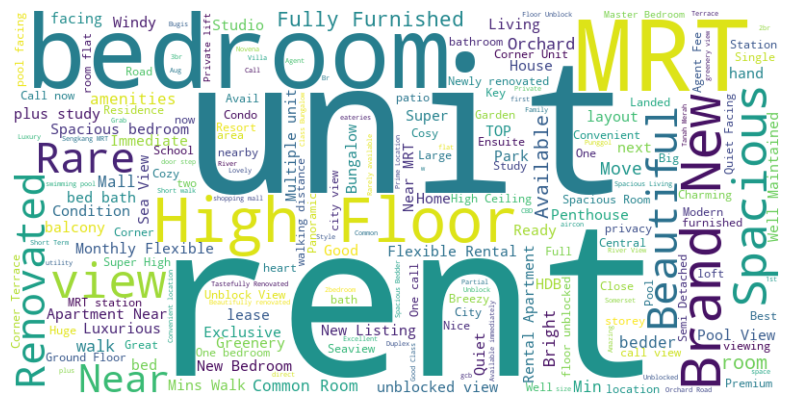

In [65]:
# Combine all agent descriptions into a single string
text = " ".join(df["agent_description"])

# Create a WordCloud object
wordcloud = WordCloud(width=800, height=400, background_color="white", random_state=7)

# Create a word cloud of the agent descriptions
wordcloud.generate(text)

# Display the word cloud 
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")  # Turn off the axis
plt.show()

In [66]:
# Save the word cloud as an image
# wordcloud.to_file("images/wordcloud.png")

Extract the following features: (1) High floor, (2) new, (3) renovated, (4) view and (5) penthouse.

## High floor

In [67]:
# Extract high floor information
df["high_floor"] = df["agent_description"].apply(lambda string: True if "high floor" in string.lower() else False)

In [68]:
# Frequency of high floor
df["high_floor"].value_counts()

False    1478
True      204
Name: high_floor, dtype: int64

## New

In [69]:
# Extract new feature
df["new"] = df["agent_description"].apply(lambda string: True if "brand new" in string.lower() or 
                                          "new unit" in string.lower() else False)

In [70]:
# Frequency of new
df["new"].value_counts()

False    1518
True      164
Name: new, dtype: int64

## Renovated

In [71]:
# Extract renovation information
df["renovated"] = df["agent_description"].apply(lambda string: True if "renovated" in string.lower() or 
                                                "renovation" in string.lower() else False)

In [72]:
# Frequency of renovated
df["renovated"].value_counts()

False    1536
True      146
Name: renovated, dtype: int64

## View

In [73]:
# Extract view feature
df["view"] = df["agent_description"].apply(lambda string: True if "sea view" in string.lower() 
                                           or "seaview" in string.lower() or "panoramic view" in string.lower()
                                           or "unblocked view" in string.lower() or "unblock view" in string.lower()
                                           or "stunning view" in string.lower() or "park view" in string.lower() 
                                           or "breathtaking view" in string.lower() or "river view" in string.lower() 
                                           or "pool view" in string.lower() or "spectacular view" in string.lower()                                          
                                           or "city view" in string.lower() or "greenery view" in string.lower() 
                                           or "gorgeous view" in string.lower() else False)

In [74]:
# Frequency of view
df["view"].value_counts()

False    1472
True      210
Name: view, dtype: int64

## Penthouse

In [75]:
# Extract penthouse information
df["penthouse"] = df["agent_description"].apply(lambda string: True if "penthouse" in string.lower() else False)

In [76]:
# Frequency of penthouse
df["penthouse"].value_counts()

False    1648
True       34
Name: penthouse, dtype: int64

# Convert data types

In [77]:
# Convert price from str to int
df["price"] = df["price"].str.replace(",", "").astype("Int32")

In [78]:
# Convert size (sqft) from str to int
df["size"] = df["size"].str.split("sqft").str[0].astype("Int32")

In [79]:
# Convert bathrooms from str to int
df["bathrooms"] = df["bathrooms"].astype("Int32")

In [85]:
# Convert meters_to_cbd from float to int
df["meters_to_cbd"] = df["meters_to_cbd"].astype("Int32")

In [80]:
# Convert meters_to_school from float to int
df["meters_to_school"] = df["meters_to_school"].astype("Int32")

# Handle missing values

## Bathrooms

In [87]:
# Average number of bathrooms by number of bedrooms
np.round(df["bathrooms"].groupby(df["bedrooms"]).mean(), 1)

bedrooms
1          1.1
10        10.0
2          1.7
3          2.5
4          4.0
5          5.0
6          6.1
7          6.4
8          8.2
9          8.0
Room      <NA>
Studio    <NA>
Name: bathrooms, dtype: Float64

In [88]:
# Assume 1 bathroom for a studio
df["bathrooms"][df["bedrooms"]=="Studio"] = 1
# Assume 1 bathroom for a room in a shared flat
df["bathrooms"][df["bedrooms"]=="Room"] = 1
# Else assume the same number as bedrooms
df["bathrooms"][pd.isna(df["bathrooms"])] = df["bedrooms"]

## Latitude and longitude

In [89]:
# Delete rows where latitude or longitude is missing 
df.dropna(subset=["latitude", "longitude"], how="any", inplace=True)

## Meters to school

In [90]:
# Descriptive statistics of meters to school
df["meters_to_school"].describe()

count    1678.000000
mean     1502.267580
std       887.015852
min         0.000000
25%       944.000000
50%      1352.500000
75%      1845.000000
max      9689.000000
Name: meters_to_school, dtype: float64

In [91]:
# Impute the maximum value if meters to school are missing
max_meters_to_school = df["meters_to_school"].max()
df["meters_to_school"] = df["meters_to_school"].fillna(max_meters_to_school)

## Meters to MRT

In [92]:
# Descriptive statistics of meters to MRT
df["meters_to_mrt"].describe()

count    1471.000000
mean      461.706322
std       228.018702
min        10.000000
25%       270.000000
50%       450.000000
75%       620.000000
max       990.000000
Name: meters_to_mrt, dtype: float64

In [93]:
# Impute the median if meters to MRT are missing
median_meters_to_mrt = df["meters_to_mrt"].median()
df["meters_to_mrt"] = df["meters_to_mrt"].fillna(median_meters_to_mrt)

## Furnishing

In [94]:
# Frequencies of furnishing
df["furnishing"].value_counts()

Partially Furnished    1012
Fully Furnished         525
Unfurnished              33
Name: furnishing, dtype: int64

In [95]:
# Impute the mode if furnishing information is missing
mode_furnishing = df["furnishing"].mode()[0]
df["furnishing"] = df["furnishing"].fillna(mode_furnishing)

## Built year

In [96]:
# Descriptive statistics of built year
df["year"].describe()

count    1409.000000
mean     2010.207949
std        11.926446
min      1974.000000
25%      2005.000000
50%      2013.000000
75%      2021.000000
max      2024.000000
Name: year, dtype: float64

In [97]:
# Impute the median if built year is missing
median_year = df["year"].median()
df["year"] = df["year"].fillna(median_year)

# Exploratory data analysis

## Numerical columns

In [102]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1680 entries, 0 to 1681
Data columns (total 25 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   name                           1680 non-null   object 
 1   address                        1575 non-null   object 
 2   price                          1680 non-null   Int32  
 3   size                           1680 non-null   Int32  
 4   bedrooms                       1680 non-null   object 
 5   bathrooms                      1680 non-null   Int32  
 6   property_type_furnishing_year  1680 non-null   object 
 7   mrt_distance                   1471 non-null   object 
 8   agent_description              1680 non-null   object 
 9   address_new                    1680 non-null   object 
 10  latitude                       1680 non-null   float64
 11  longitude                      1680 non-null   float64
 12  meters_to_cbd                  1680 non-null   I

In [103]:
# Store numerical columns
numerical_columns = ["price", "size", "bathrooms", "meters_to_mrt", "meters_to_cbd", "meters_to_school", 
                     "restaurants_rating", "year"]

### Table: Descriptive statistics 

In [104]:
# Overview of descriptive statistics of all numerical columns
df[numerical_columns].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
price,1680.0,9134.447024,14117.921225,500.00,3900.000000,5200.000,8559.750000,300000.00
size,1680.0,1590.883929,2013.075525,50.00,624.000000,974.500,1593.000000,25000.00
bathrooms,1680.0,2.400595,1.512190,1.00,1.000000,2.000,3.000000,10.00
meters_to_mrt,1680.0,460.250000,213.390474,10.00,300.000000,450.000,590.000000,990.00
meters_to_cbd,1680.0,10749.559524,6674.210236,756.00,4834.000000,10302.500,15146.250000,30522.00
meters_to_school,1680.0,1512.013690,930.376899,0.00,944.000000,1353.000,1846.750000,9689.00
restaurants_rating,1680.0,4.000766,0.225784,2.76,3.836455,4.035,4.166667,4.71
year,1680.0,2010.658333,10.969824,1974.00,2008.000000,2013.000,2017.000000,2024.00


### Price

In [105]:
# Descriptive statistics
df["price"].describe()

count      1680.000000
mean       9134.447024
std       14117.921225
min         500.000000
25%        3900.000000
50%        5200.000000
75%        8559.750000
max      300000.000000
Name: price, dtype: float64

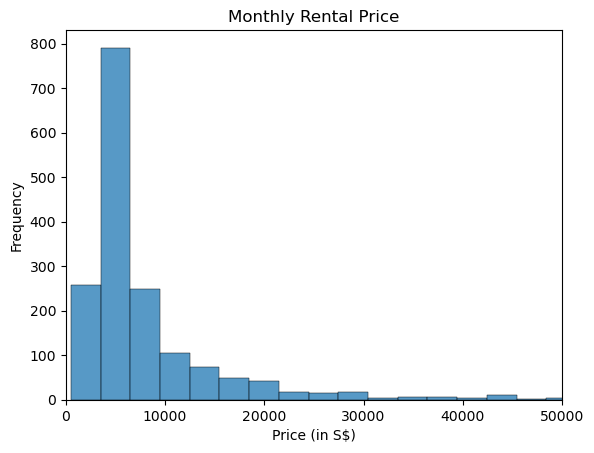

In [118]:
# Create a histogram 
sns.histplot(df["price"], bins=100)

# Add axes labels 
plt.xlabel("Price (in S$)")
plt.ylabel("Frequency")

# Set x-axis limits
plt.xlim(0, 50000)

# Add title
plt.title("Monthly Rental Price")

# Show the plot
plt.show()

#### Price correlations

In [121]:
# Correlations between price and all numerical and dichotomous columns
df[["price", "size", "bathrooms", "meters_to_mrt", "meters_to_school", "year", "high_floor", "new", "renovated", 
    "view", "penthouse"]].corr()["price"].sort_values(ascending=False)

price               1.000000
size                0.854721
bathrooms           0.678774
penthouse           0.104377
meters_to_mrt       0.056423
meters_to_school    0.047953
year                0.019606
renovated           0.003661
view               -0.044754
high_floor         -0.049258
new                -0.075268
Name: price, dtype: float64

#### Price scatterplots

In [ ]:
# Set the figure size
plt.figure(figsize=(12, 12))

# Iterate over the five numerical columns
for i, col in enumerate(["size", "bathrooms", "meters_to_mrt", "meters_to_school", "year"]):
    # Create a subplot in a 2x3 grid, the current subplot is i+1
    plt.subplot(3, 2, i + 1)
    # Create a scatter plot between the current column and price
    sns.scatterplot(data=df, x=col, y="price")
    # Add axis labels
    plt.ylabel("Price in S$")
    plt.xlabel(f"{col}")
    # Add title
    plt.title(f"Price by {col}")

# Adjust subplot layout
plt.tight_layout()

# Show the plot
plt.show()

#### Price by bedrooms

In [ ]:
# Descriptive statistics of price by bedrooms
price_by_bedrooms = df["price"].groupby(df["bedrooms"])
price_by_bedrooms.describe()

In [ ]:
# Store median price by bedrooms in the desired order
median_price_by_bedrooms = price_by_bedrooms.median().reindex(["Room", "Studio", "1", "2", "3", "4", "5", "6", "7", 
                                                              "8", "9"])

In [ ]:
# Bar plot
sns.barplot(x=median_price_by_bedrooms.index, y=median_price_by_bedrooms.values, palette="colorblind")

# Add axes labels 
plt.ylabel("Price in S$")
plt.xlabel("Bedrooms")

# Add title
plt.title("Median price by bedrooms")

# Show the plot
plt.show()

#### Price by property type

In [ ]:
# Descriptive statistics of price by property type
price_by_type = df["price"].groupby(df["property_type"])
price_by_type.describe()

In [ ]:
# Store median price by property type in the desired order
median_price_by_type = price_by_type.median().reindex(["HDB Flat", "Apartment", "Condominium", "Corner Terrace",
                                                      "Semi-Detached House", "Good Class Bungalow", "Cluster House",
                                                      "Terraced House", "Detached House"])
median_price_by_type

In [ ]:
# Bar plot
sns.barplot(x=median_price_by_type.index, y=median_price_by_type.values, palette="colorblind")

# Add axes labels
plt.xlabel("Property type")
plt.ylabel("Price in S$")

# Rotate x-axis tick labels by 45 degrees
plt.xticks(rotation=45)

# Add title
plt.title("Median price by property type")

# Show the plot
plt.show()

#### Price by furnishing

In [ ]:
# Descriptive statistics of price by furnishing
price_by_furnishing = df["price"].groupby(df["furnishing"])
price_by_furnishing.describe()

In [ ]:
# Store median price by furnishing
median_price_by_furnishing = price_by_furnishing.median()

In [ ]:
# Bar plot
sns.barplot(x=median_price_by_furnishing.index, y=median_price_by_furnishing.values, palette="colorblind")

# Add axes labels
plt.ylabel("Price in S$")
plt.xlabel("")

# Add title
plt.title("Median price by furnishing")

# Show the plot
plt.show()

#### Price by high floor, new, renovated, view and penthouse

In [ ]:
# Descriptive statistics of price by high floor, new, renovated, view and penthouse
for col in ["high_floor", "new", "renovated", "view", "penthouse"]:
    print(f"Price by {col}:")
    print(round(df["price"].groupby(df[col]).describe()))
    print("-" * 80)

In [ ]:
# Bar plots of price by high floor, new, renovated, view and penthouse
# Set the figure size
plt.figure(figsize=(12, 6))

# Iterate over the five dichotomous columns
for i, col in enumerate(["high_floor", "new", "renovated", "view", "penthouse"]):
    # Create a subplot in a 2x3 grid, the current subplot is i+1
    plt.subplot(2, 3, i + 1)
    # Create a bar plot of median price by the current column
    ax = sns.barplot(data=df, x=col, y="price", estimator=np.median, ci=None)
    # Add axes labels
    plt.ylabel("Price in S$")
    plt.xlabel("")
    # Set y-axis limits
    ax.set_ylim(0, 13000)
    # Add title
    plt.title(f"Median price by {col}")

# Adjust subplot layout
plt.tight_layout()

# Show the plot
plt.show()

### Size

In [ ]:
# Descriptive statistics
df["size"].describe()

In [ ]:
# Create a histogram 
sns.histplot(df["size"], bins=30)

# Add axes labels 
plt.xlabel("Size (in sqft)")
plt.ylabel("Frequency")

# Set x-axis limits
# plt.xlim(0, 3900)

# Add title
plt.title("Property Size")

# Show the plot
plt.show()

### Bathrooms

In [ ]:
# Descriptive statistics
df["bathrooms"].describe()

In [ ]:
# Create a histogram 
sns.histplot(df["bathrooms"])

# Add axes labels 
plt.xlabel("Number of bathrooms")
plt.ylabel("Frequency")

# Add title
plt.title("Bathrooms")

# Show the plot
plt.show()

### Meters to MRT

In [ ]:
# Descriptive statistics
df["meters_to_mrt"].describe()

In [ ]:
# Create a histogram 
sns.histplot(df["meters_to_mrt"])

# Add axes labels 
plt.xlabel("Meters to MRT")
plt.ylabel("Frequency")

# Add title
plt.title("Meters to MRT")

# Show the plot
plt.show()

### Meters to school

In [ ]:
# Descriptive statistics
df["meters_to_school"].describe()

In [ ]:
# Create a histogram 
sns.histplot(df["meters_to_school"])

# Add axes labels 
plt.xlabel("Meters to school")
plt.ylabel("Frequency")

# Add title
plt.title("Meters to school")

# Show the plot
plt.show()

### Built year

In [ ]:
# Descriptive statistics
df["year"].describe()

In [ ]:
# Create a histogram 
sns.histplot(df["year"])

# Set x-axis markers every 5 years
plt.xticks(range(1975, 2026, 5))

# Add axes labels 
plt.xlabel("Built year")
plt.ylabel("Frequency")

# Add title
plt.title("Built year")

# Show the plot
plt.show()

## Categorical columns

In [ ]:
# Store categorical columns
categorical_columns = ["bedrooms", "property_type", "furnishing", "high_floor", "new", "renovated", "view", 
                       "penthouse"]

### Bedrooms

In [ ]:
# Calculate frequencies
bedrooms_freq = df["bedrooms"].value_counts()

# Reorder categories
bedrooms_freq = bedrooms_freq.reindex(["Room", "Studio", "1", "2", "3", "4", "5", "6", "7", "8", "9"])

# Display frequencies
print("Absolute frequencies:")
print(bedrooms_freq)

print("\nRelative frequencies:")
for category, frequency in bedrooms_freq.iteritems():
    print(f"{category}: {100 * frequency/bedrooms_freq.sum():.1f}%")

In [ ]:
# Bar plot
sns.barplot(x=bedrooms_freq.index, y=bedrooms_freq.values, palette="colorblind")

# Add axes labels 
plt.ylabel("Frequency")

# Add title
plt.title("Bedrooms")

# Show the plot
plt.show()

### Property type

In [ ]:
# Calculate frequencies
property_type_freq = df["property_type"].value_counts()

# Display frequencies
print("Absolute frequencies:")
print(property_type_freq)

print("\nRelative frequencies:")
for category, frequency in property_type_freq.iteritems():
    print(f"{category}: {100 * frequency/property_type_freq.sum():.1f}%")

In [ ]:
# Bar plot
sns.barplot(x=property_type_freq.index, y=property_type_freq.values, palette="colorblind")

# Add axes labels 
plt.ylabel("Frequency")

# Rotate x-axis tick labels by 45 degrees
plt.xticks(rotation=45)

# Add title
plt.title("Property type")

# Show the plot
plt.show()

### Furnishing

In [ ]:
# Calculate frequencies
furnishing_freq = df["furnishing"].value_counts()

# Display frequencies
print("Absolute frequencies:")
print(furnishing_freq)

print("\nRelative frequencies:")
for category, frequency in furnishing_freq.iteritems():
    print(f"{category}: {100 * frequency/furnishing_freq.sum():.1f}%")

In [ ]:
# Bar plot
sns.barplot(x=furnishing_freq.index, y=furnishing_freq.values, palette="colorblind")

# Add axes labels 
plt.ylabel("Frequency")

# Add title
plt.title("Furnishing")

# Show the plot
plt.show()

### High floor

In [ ]:
# Frequencies
print("Absolute frequencies:")
print(df["high_floor"].value_counts())

print("\nRelative frequencies:")
print(f'False: {np.round(100 * df["high_floor"].value_counts()[False] / df["high_floor"].value_counts().sum(), 1)}%')
print(f'True: {np.round(100 * df["high_floor"].value_counts()[True] / df["high_floor"].value_counts().sum(), 1)}%')

In [ ]:
# Bar plot
sns.barplot(x=df["high_floor"].value_counts().index, y=df["high_floor"].value_counts().values)

# Add axes labels 
plt.ylabel("Frequency")

# Add title
plt.title("High floor")

# Show the plot
plt.show()

### New

In [ ]:
# Frequencies
print("Absolute frequencies:")
print(df["new"].value_counts())

print("\nRelative frequencies:")
print(f'False: {np.round(100 * df["new"].value_counts()[False] / df["new"].value_counts().sum(), 1)}%')
print(f'True: {np.round(100 * df["new"].value_counts()[True] / df["new"].value_counts().sum(), 1)}%')

In [ ]:
# Bar plot
sns.barplot(x=df["new"].value_counts().index, y=df["new"].value_counts().values)

# Add axes labels 
plt.ylabel("Frequency")

# Add title
plt.title("New")

# Show the plot
plt.show()

### Renovated

In [ ]:
# Frequencies
print("Absolute frequencies:")
print(df["renovated"].value_counts())

print("\nRelative frequencies:")
print(f'False: {np.round(100 * df["renovated"].value_counts()[False] / df["renovated"].value_counts().sum(), 1)}%')
print(f'True: {np.round(100 * df["renovated"].value_counts()[True] / df["renovated"].value_counts().sum(), 1)}%')

In [ ]:
# Bar plot
sns.barplot(x=df["renovated"].value_counts().index, y=df["renovated"].value_counts().values)

# Add axes labels 
plt.ylabel("Frequency")

# Add title
plt.title("Renovated")

# Show the plot
plt.show()

### View

In [ ]:
# Frequencies
print("Absolute frequencies:")
print(df["view"].value_counts())

print("\nRelative frequencies:")
print(f'False: {np.round(100 * df["view"].value_counts()[False] / df["view"].value_counts().sum(), 1)}%')
print(f'True: {np.round(100 * df["view"].value_counts()[True] / df["view"].value_counts().sum(), 1)}%')

In [ ]:
# Bar plot
sns.barplot(x=df["view"].value_counts().index, y=df["view"].value_counts().values)

# Add axes labels 
plt.ylabel("Frequency")

# Add title
plt.title("View")

# Show the plot
plt.show()

### Penthouse

In [ ]:
# Frequencies
print("Absolute frequencies:")
print(df["penthouse"].value_counts())

print("\nRelative frequencies:")
print(f'False: {np.round(100 * df["penthouse"].value_counts()[False] / df["penthouse"].value_counts().sum(), 1)}%')
print(f'True: {np.round(100 * df["penthouse"].value_counts()[True] / df["penthouse"].value_counts().sum(), 1)}%')

In [ ]:
# Bar plot
sns.barplot(x=df["penthouse"].value_counts().index, y=df["penthouse"].value_counts().values)

# Add axes labels 
plt.ylabel("Frequency")

# Add title
plt.title("Penthouse")

# Show the plot
plt.show()

## Correlations

In [ ]:
# Calculate the correlation matrix 
corr_matrix = df[["price", "size", "bathrooms", "meters_to_mrt", "meters_to_school", "year", "high_floor", "new", 
                  "renovated", "view", "penthouse"]].corr()

# Round correlations to two decimals
corr_matrix = round(corr_matrix, 2)

# Create a mask to set the values in the upper triangle of the correlation matrix to NaN
mask = np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
corr_matrix[mask] = np.nan

# Show correlation matrix
corr_matrix

In [ ]:
# Correlation heatmap
# Set the figure size
plt.figure(figsize=(8, 6))

# Create heatmap
sns.heatmap(corr_matrix, cmap="viridis", annot=True, linewidth=0.5)

# Add title
plt.title("Correlation heatmap")

# Save the heatmap as png
plt.savefig("images/correlation_heatmap.png", bbox_inches="tight")

# Show the plot
plt.show()

## Property locations on the map

In [ ]:
import folium

In [ ]:
# Create a map centered around Singapore
map = folium.Map(location=[1.3521, 103.8198], zoom_start=12) 

# Add property markers to the map
for index, row in df.iterrows():
    folium.Marker(
        location=[row["latitude"], row["longitude"]],
        tooltip=row["name"],  # Display property name on hover
    ).add_to(map)

# Show map
map

In [ ]:
# Save the map as an HTML file
# map.save("images/map.html")  

# Save preprocessed data

In [ ]:
# Delete columns that are no longer needed
df.drop(["name", "address", "property_type_furnishing_year", "mrt_distance", "agent_description", "school_location", 
         "address_new"], axis=1, inplace=True)

In [ ]:
# Save preprocessed data as csv
# df.to_csv("data/rental_prices_singapore_preprocessed.csv", index=False)